In [1]:
import datetime
import glob
import os

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.stats as stats
import tensorflow as tf
from tqdm import tqdm

import utils

In [2]:
chour_dict = {'morning':'04',
              'afternoon':'12',
             }

ampm = 'morning'

critical_hour = chour_dict[ampm]


df = pd.read_csv(f'merged_df_{ampm}.csv',parse_dates=['time'])
time = df['time']
df = df.drop(['time','tmpf','tmpf_pred','lt_32','p01i','p01i_pred'],axis=1)
df = df.interpolate('linear')
df.head()

,speed,hour,speed_diff
0,1.665056,0.512212,0.05817
1,1.671025,0.611799,0.17636
2,1.676994,0.698988,0.17636
3,1.682963,0.773405,0.17636
4,1.688933,0.834731,0.17636


In [3]:
(train_df,val_df,test_df), num_features = utils.train_test_val_split(df)

In [4]:
input_width = 8
label_width = 8
shift = label_width 

In [5]:
w1 = utils.WindowGenerator(input_width, label_width, shift,train_df, val_df, test_df, label_columns=['speed'])
w1

Total window size: 16
Input indices: [0 1 2 3 4 5 6 7]
Label indices: [ 8  9 10 11 12 13 14 15]
Label column name(s): ['speed']

In [6]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 16, 3)
Inputs shape: (3, 8, 3)
labels shape: (3, 8, 1)


In [7]:
w1.make_dataset(w1.train_df)

test_case = w1.train_df.copy()

In [8]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 8, 3)
Labels shape (batch, time, features): (32, 8, 1)


In [9]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [10]:
print('Input shape:', w1.example[0].shape)
print('Output shape:', linear(w1.example[0]).shape)

Input shape: (32, 8, 3)
Output shape: (32, 8, 1)


In [11]:
val_performance = {}
performance = {}

In [12]:
history = utils.compile_and_fit(linear, w1)

val_performance['Linear'] = linear.evaluate(w1.val)
performance['Linear'] = linear.evaluate(w1.test, verbose=0)

Epoch 1/20
546/546 [==============================] - 2s 4ms/step - loss: 2.2441 - mean_absolute_error: 1.1662 - val_loss: 0.9154 - val_mean_absolute_error: 0.7681
Epoch 2/20
546/546 [==============================] - 3s 5ms/step - loss: 0.9346 - mean_absolute_error: 0.7536 - val_loss: 0.4534 - val_mean_absolute_error: 0.5506
Epoch 3/20
546/546 [==============================] - 3s 5ms/step - loss: 0.5748 - mean_absolute_error: 0.6059 - val_loss: 0.3633 - val_mean_absolute_error: 0.5008
Epoch 4/20
546/546 [==============================] - 2s 5ms/step - loss: 0.5043 - mean_absolute_error: 0.5723 - val_loss: 0.3549 - val_mean_absolute_error: 0.4960
Epoch 5/20
156/156 [==============================] - 2s 14ms/step - loss: 0.3554 - mean_absolute_error: 0.4956


In [13]:
performance['Linear']

[0.4353528618812561, 0.5386165380477905]

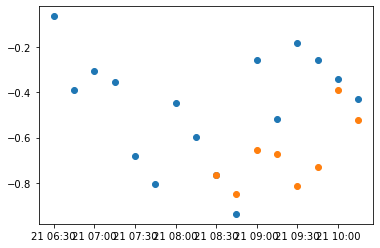

In [14]:
# plt.plot()
ind_0 = np.random.randint(0,len(df)-1)
width = 8

prediction = linear.predict(df[ind_0:ind_0+width])

plt.scatter(time[ind_0:ind_0+2*width],df[ind_0:ind_0+2*width]['speed'].values)

plt.scatter(time[ind_0+width:ind_0+2*width],prediction)

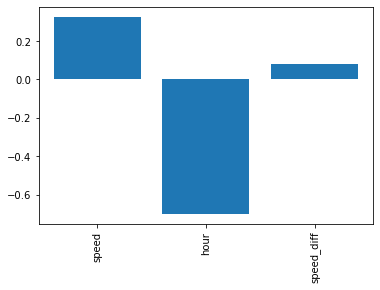

In [15]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [16]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = utils.compile_and_fit(dense, w1)

val_performance['Dense'] = dense.evaluate(w1.val)
performance['Dense'] = dense.evaluate(w1.test, verbose=0)

Epoch 1/20
546/546 [==============================] - 4s 8ms/step - loss: 0.4509 - mean_absolute_error: 0.5294 - val_loss: 0.3334 - val_mean_absolute_error: 0.4669
Epoch 2/20
546/546 [==============================] - 3s 5ms/step - loss: 0.3730 - mean_absolute_error: 0.4679 - val_loss: 0.2625 - val_mean_absolute_error: 0.3926
Epoch 3/20
546/546 [==============================] - 5s 9ms/step - loss: 0.3388 - mean_absolute_error: 0.4350 - val_loss: 0.2460 - val_mean_absolute_error: 0.3799
Epoch 4/20
546/546 [==============================] - 3s 5ms/step - loss: 0.3269 - mean_absolute_error: 0.4245 - val_loss: 0.2447 - val_mean_absolute_error: 0.3745
Epoch 5/20
546/546 [==============================] - 4s 8ms/step - loss: 0.3208 - mean_absolute_error: 0.4186 - val_loss: 0.2427 - val_mean_absolute_error: 0.3753
Epoch 6/20
546/546 [==============================] - 3s 5ms/step - loss: 0.3178 - mean_absolute_error: 0.4156 - val_loss: 0.2363 - val_mean_absolute_error: 0.3693
Epoch 7/20
156/1

In [17]:
time_test = time[w1.test_df.index]

(-2.5, 1.5)

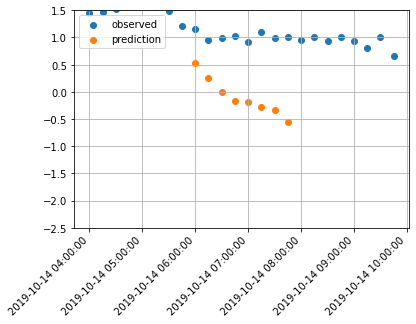

In [18]:
forecast_starts = pd.date_range(f'2015-01-01 {critical_hour}',f'2019-12-31 {critical_hour}',freq='24h')
valid_inds = time_test[time_test.isin(forecast_starts)].index
rand_ind = np.random.randint(0,len(valid_inds)-1)
ind_0 = valid_inds[rand_ind]

width = 8
ticks = '1H'

prediction = dense.predict(df[ind_0:ind_0+width])

plt.scatter(time[ind_0:ind_0+3*width],df[ind_0:ind_0+3*width]['speed'].values,label='observed')

plt.scatter(time[ind_0+width:ind_0+2*width],prediction,label='prediction')

plt.grid()
start = time.loc[ind_0]
end = time.loc[ind_0+3*width]
dates = pd.date_range(start=start,end=end,freq=ticks)
plt.xticks(ticks = dates,labels = dates,rotation=45,ha='right',size=10)
plt.legend()
plt.ylim(-2.5,1.5)

In [19]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(label_width*num_features,
                          kernel_initializer=tf.keras.initializers.glorot_normal(),
                          bias_initializer=tf.keras.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([label_width, num_features])
])

history = utils.compile_and_fit(multi_lstm_model, w1)

val_performance['LSTM'] = multi_lstm_model.evaluate(w1.val)
performance['LSTM'] = multi_lstm_model.evaluate(w1.test, verbose=0)

Epoch 1/20
546/546 [==============================] - 7s 13ms/step - loss: 0.3404 - mean_absolute_error: 0.4362 - val_loss: 0.2041 - val_mean_absolute_error: 0.3340
Epoch 2/20
546/546 [==============================] - 5s 8ms/step - loss: 0.2110 - mean_absolute_error: 0.3382 - val_loss: 0.1781 - val_mean_absolute_error: 0.3117
Epoch 3/20
546/546 [==============================] - 5s 10ms/step - loss: 0.1921 - mean_absolute_error: 0.3208 - val_loss: 0.1658 - val_mean_absolute_error: 0.3006
Epoch 4/20
546/546 [==============================] - 5s 10ms/step - loss: 0.1811 - mean_absolute_error: 0.3105 - val_loss: 0.1541 - val_mean_absolute_error: 0.2881
Epoch 5/20
546/546 [==============================] - 5s 10ms/step - loss: 0.1729 - mean_absolute_error: 0.3020 - val_loss: 0.1491 - val_mean_absolute_error: 0.2799
Epoch 6/20
546/546 [==============================] - 5s 9ms/step - loss: 0.1666 - mean_absolute_error: 0.2958 - val_loss: 0.1414 - val_mean_absolute_error: 0.2739
Epoch 7/20
5

(-2.5, 1.5)

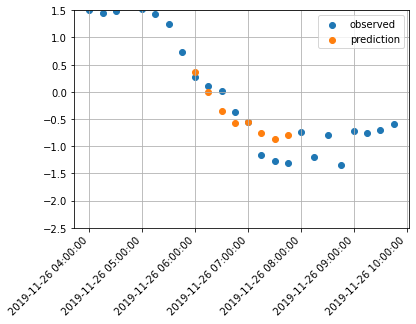

In [25]:
rand_ind = np.random.randint(0,len(valid_inds)-1)
ind_0 = valid_inds[rand_ind]

width = 8
ticks = '1H'

prediction = multi_lstm_model.predict(df[ind_0:ind_0+width].values[np.newaxis,])

prediction = prediction[0,:,1]

plt.scatter(time[ind_0:ind_0+3*width],df[ind_0:ind_0+3*width]['speed'].values,label='observed')

plt.scatter(time[ind_0+width:ind_0+2*width],prediction,label='prediction')

plt.grid()
start = time.loc[ind_0]
end = time.loc[ind_0+3*width]
dates = pd.date_range(start=start,end=end,freq=ticks)
plt.xticks(ticks = dates,labels = dates,rotation=45,ha='right',size=10)
plt.legend()
plt.ylim(-2.5,1.5)

In [21]:
multi_lstm_model.save(f'no_weather_{ampm}')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: no_weather_morning/assets
